In [11]:
import math
from scipy import optimize
import matplotlib.pyplot as plt
import num_methods as nm
from drawing import *

In [12]:
# TODO: remove list, можно использовать предыдущее значение
def newtonsMethod(a, c, T, y, b, x):
    l = [x]  # list of x(y) values
    for _ in range(100):
        xn = l[-1]  # previous value of x
        y_x = ((-xn+c)*T+y)/(1+b*T)  # y выраженный через х

        f = -xn+(-a*(xn**3/3-xn) + a*y_x)*T+x  # вот это есть в классе
        g = -1+a*T*(-T/(b*T+1)-xn**2+1)

        l.append(l[-1] - f/g)
    return l[-1]

In [13]:
"""Неявный метод Эйлера 1-го порядка"""
def implicit_method(T, xvn, yvn, a, c, b):
    xn2 = newtonsMethod(a, c, T, yvn, b, xvn)
    yn2 = (T*(-xn2+c) + yvn)/(1+b*T)
    return (xn2, yn2)

[scipy root](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html),
[Jacobian](<https://math.libretexts.org/Bookshelves/Calculus/Supplemental_Modules_(Calculus)/Vector_Calculus/3%3A_Multiple_Integrals/3.8%3A_Jacobians>)


In [14]:

def fx(t, xvn, yvn, a, b, c):
    return -a*((xvn**3)/3-xvn) + a*yvn

def fy(t, xvn, yvn, a, b, c):
    return -xvn + c - b*yvn

In [15]:
# новый шаг
def get_p(array):
    s = sum([i ** 2 for i in array])
    return math.sqrt(s)

# T0 - максимальный возможный шаг
def new_T(last_T, T0, array, array_prev, L):
    p = get_p(array)
    F = [i / p for i in array]
    p_prev = get_p(array_prev)
    F_prev = [i / p_prev for i in array_prev]
    X = [(F[i] - F_prev[i]) / last_T for i in range(len(F))]
    XX = sum([i ** 2 for i in X])
    new_T = T0 / (1 + math.sqrt(L) * XX ** (1/4))
    return new_T

def do_method(method, t_start, t_finish, tl, array, variables, dynamic_step: bool=True):
    T, a, b, c = [i for i in variables]
    max_step = T

    array_T = [T]
    array_dif = [(fx(1, array[-1][0], array[-1][1], a, b, c),
                    fy(1, array[-1][0], array[-1][1], a, b, c))]
    while tl[-1] <= t_finish:
        array.append(method(T, array[-1][0], array[-1][1], a, c, b))
        array_dif.append((fx(1, array[-1][0], array[-1][1], a, b, c),
                fy(1, array[-1][0], array[-1][1], a, b, c)))
        if dynamic_step:
            T = new_T(array_T[-1], max_step, array[-1], array[-2], t_finish - t_start)
        array_T.append(T)
        tl.append(tl[-1] + T)
    return (tl, array, array_dif)

$x' = -a(\frac{x^3}{3} - x) - ay$\
$y' = -x - by + c$\
$x(0) = 2,\quad y(0) = 0$\
Здесь 1 $\leq$ _a_ $\leq$ 10^3, 0 < _c_ < 1.
Провести исследование поведения решений в зависимости от значений «большого» параметра _a_.


In [16]:
# неявный 1
def jac1(T, xvn, yvn, t, table, k, a):
  def jac_f(x):
    return [[-a * (x[0] * x[1] + 2) * T - 1, (-a * x[0] * x[0] - 1) * T],
            [T * 1, T * 1 - 1]]
  return jac_f

def jac2(T, xvn, yvn, t, table, k, ak):
    def jac_f(x):
      xn = [xvn + table.a[1][0] * k[0] + table.a[1][1] * x[0], xvn + table.a[1][0] * k[0] + table.a[1][1] * x[0]]
      yn = [yvn + table.a[1][0] * k[1] + table.a[1][1] * x[1], yvn + table.a[1][0] * k[1] + table.a[1][1] * x[1]]
      return [[-ak * (2 * xn[0] * yn[0] * table.a[1][1] + 2 * table.a[1][1]) * T - 1,
               (-ak * xn[0] * xn[0] - 1 * table.a[1][1]) * T],
              [T * 1 * table.a[1][1],
               T * 1 * table.a[1][1] - 1]]
    return jac_f

In [17]:
# from num_methods import Solver2
# from test_methods import Test2
# from statistics import mean
# import numpy as np

# t_start = 0
# t_finish = 100
# a = 1
# b = 0.6
# for c in np.linspace(0.1, 1, 10):
#      # c = 0.6
#      sol = Solver2((fx, fy), [jac1, jac2], [a, b, c], (2, 0), (t_start, t_finish))
#      array = sol.do_method(sol.explicit1, 0.001, True)
#      arrayx1 = [i[0] for i in array[1]]
#      arrayy1 = [i[1] for i in array[1]]
#      if round(mean(arrayx1[-100:]), 3) == round(mean(arrayx1[-200:]), 3):
#           print("c: ", c)
#           print("x: ", mean(arrayx1[-100:]))
#           print("y: ", mean(arrayy1[-100:]))
#           print()
#      # main_array.append(arrayx3)
#      # print(len(array1[0]), len(array2[0]), len(arrayx1), len(arrayx2))
#      # array_dif_x3 = [[i[0] for i in array3_dif]]
#      draw([array[0], array[0]],
#           [arrayx1, arrayy1],
#           ["Явный метод 5-го порядка", "Неявный метод 2-го порядка"], ["a", "b"])
#      # draw([[i[0] for i in array2[2]]], [arrayx2], ["x' from x"])

### Сравнение с решением с помощью SciPy


In [18]:
# from scipy.integrate import ode

# def f(t, y, a, b, c):
#   return [a*(y[0] + y[1] - y[0]**3/3),
#           c - y[0] - b*y[1]]

# def jac(t, y, a, b, c):
#   return [[a*(1 - y[0]**2),  a],
#           [             -1, -b]]

# y01, y02 = 2., 0.
# r = ode(f, jac).set_integrator('vode', method='adams', with_jacobian=True)
# r.set_initial_value((y01, y02)).set_f_params(a, b, c).set_jac_params(a, b, c)

# t1, dt, t, y1, y2 = t_finish, T, [0.], [y01], [y02]
# while r.successful() and r.t < t1:
#   r.integrate(r.t + dt)
#   t.append(r.t)
#   y1.append(r.y[0])
#   y2.append(r.y[1])

# draw([array1[0], array2[0], t],
#      [arrayx1, arrayx2, y1],
#       [f"Явный метод 5-го порядка", "Неявный метод 2-го порядка", f"Scipy"])

Веселые рисунки


AttributeError: 'Solver2' object has no attribute 'explicit1_method'

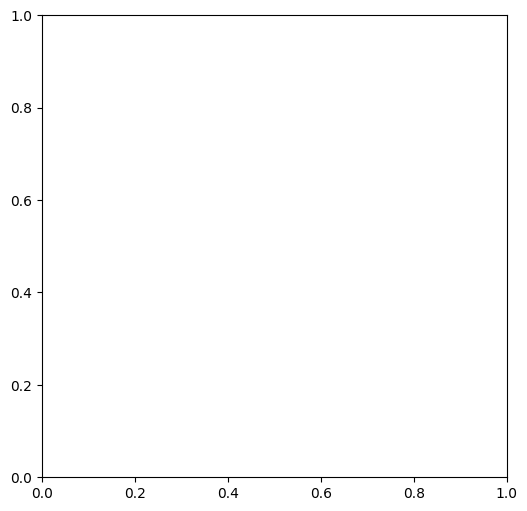

In [19]:
T = 0.01
t_start = 0
t_finish = 40
a = 1
# fig1 = plt.figure(figsize=(10,18))
# px1 = fig1.add_subplot(111)
# fig2 = plt.figure(figsize=(14, 14))
# px2 = fig2.add_subplot(111)
fig3 = plt.figure(figsize=(6, 6))
px3 = fig3.add_subplot(111)
a = 8
while a <= 8:
    c = 0.5
    b = 0.60
    # Первый элемент это x, второй y
    variables = (T, a, b, c)
    array0 = [(2, 0)]
    array1 = sol.do_method(sol.explicit1, T, False)
    array2 = do_method(implicit_method, t_start, t_finish, [t_start], [(-1, 0)], variables)

    arrayx1 = [i[0] for i in array1[1]]
    arrayx2 = [i[0] for i in array2[1]]

    # main_array.append(arrayx3)
    # print(len(array1[0]), len(array2[0]), len(arrayx1), len(arrayx2))
    # array_dif_x3 = [[i[0] for i in array3_dif]]
    # draw([array1[0], array2[0]],
    #     [arrayx1, arrayx2],
    #     [f"явный 1-го порядка {len(array1[0])}", f"неявный 2го"])
    # draw_on_plot([arrayx2], [[i[0] for i in array2[2]]], [f"{round(a, 3)} value"], px1)
    # draw([[i[0] for i in array2[2]]], [arrayx2], [f"{a} value"])
    # draw_on_plot([[i[1] for i in array2[1]]], [[i[1] for i in array2[2]]], [f"{round(a, 3)} value"], px2)
    draw_on_plot([arrayx2], [[i[1] for i in array2[1]]], [f"a value: {round(a, 3)}"], px3)
    a *= 1.2
# px1.legend(loc='upper left')
# px2.legend(loc='upper left')
px3.legend(loc='upper left')

In [ ]:
T = 0.01
t_start = 0
t_finish = 40
a = 1
fig1 = plt.figure(figsize=(8,8))
px1 = fig1.add_subplot(111)
fig2 = plt.figure(figsize=(8, 8))
px2 = fig2.add_subplot(111)
fig3 = plt.figure(figsize=(14, 14))
px3 = fig3.add_subplot(111)
while a <= 32:
    c = 0.4
    b = 0.60
    # Первый элемент это x, второй y
    variables = (T, a, b, c)
    array0 = [(2, 0)]
    array1 = sol.do_method(sol.explicit1_method, T, False)
    array2 = do_method(implicit_method, t_start, t_finish, [t_start], [(2, 0)], variables)

    arrayx1 = [i[0] for i in array1[1]]
    arrayx2 = [i[0] for i in array2[1]]
    arrayy2 = [i[1] for i in array2[1]]
    # main_array.append(arrayx3)
    # print(len(array1[0]), len(array2[0]), len(arrayx1), len(arrayx2))
    # array_dif_x3 = [[i[0] for i in array3_dif]]
    # draw([array1[0], array2[0]],
    #     [arrayx1, arrayx2],
    #     [f"явный 1-го порядка {len(array1[0])}", f"неявный 2го"])
    draw_on_plot([array2[0]], [arrayx2], [f"a = {round(a, 3)}"], px1)
    draw_on_plot([array2[0]], [arrayy2], [f"a = {round(a, 3)}"], px2)
    # draw([[i[0] for i in array2[2]]], [arrayx2], [f"{a} value"])
    # draw_on_plot([[i[1] for i in array2[1]]], [[i[1] for i in array2[2]]], [f"{round(a, 3)} value"], px2)
    # draw_on_plot([arrayx2], [[i[1] for i in array2[1]]], [f"a value: {round(a, 3)}"], px3)
    a *= 3
ls = 15
fs = 6
fonts = 15
px1.tick_params(axis="both", which="major", labelsize=ls)
px1.set_xlabel("t", fontsize = fonts)
px1.set_ylabel("X", fontsize = fonts)
px1.legend(fontsize=fonts-3)
px2.tick_params(axis="both", which="major", labelsize=ls)
px2.set_xlabel("t", fontsize = fonts)
px2.set_ylabel("Y", fontsize = fonts)
px2.legend(fontsize=fonts-3)
px1.legend(loc='upper left')
px2.legend(loc='upper left')
px3.legend(loc='upper left')

NameError: name 'plt' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


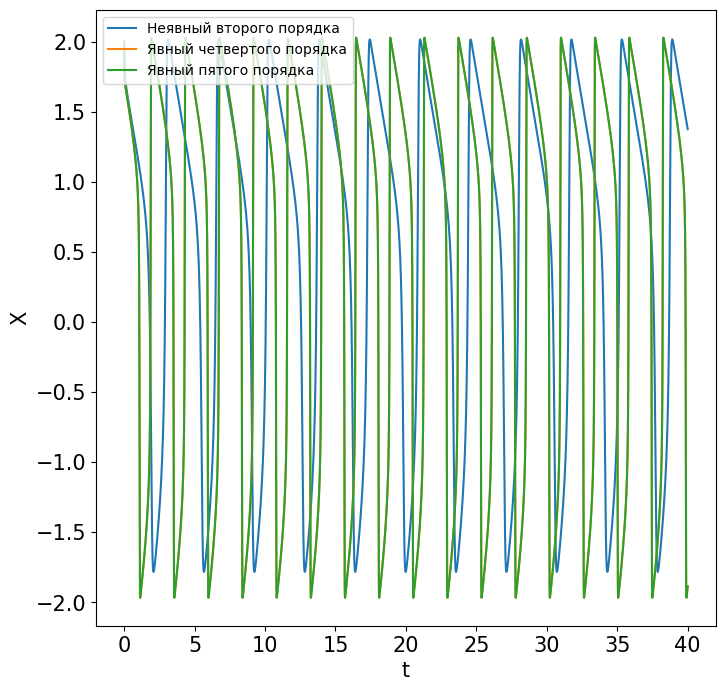

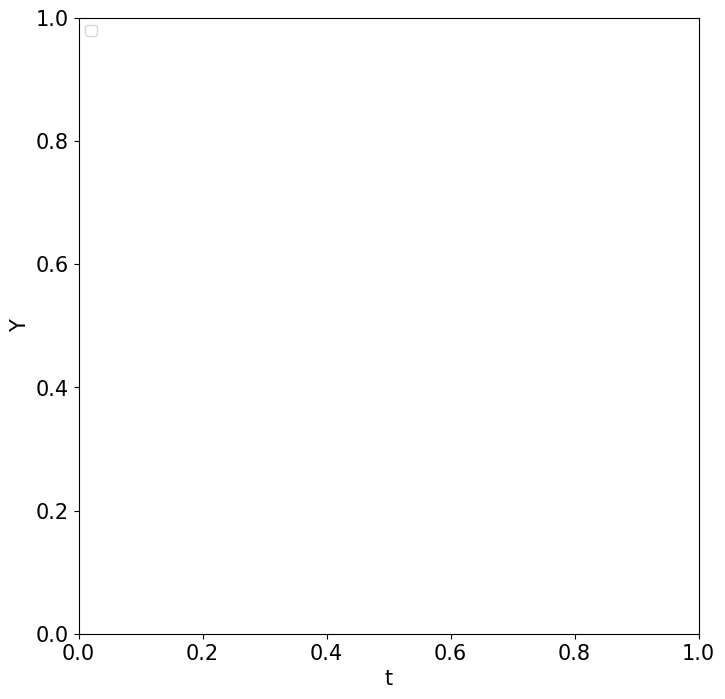

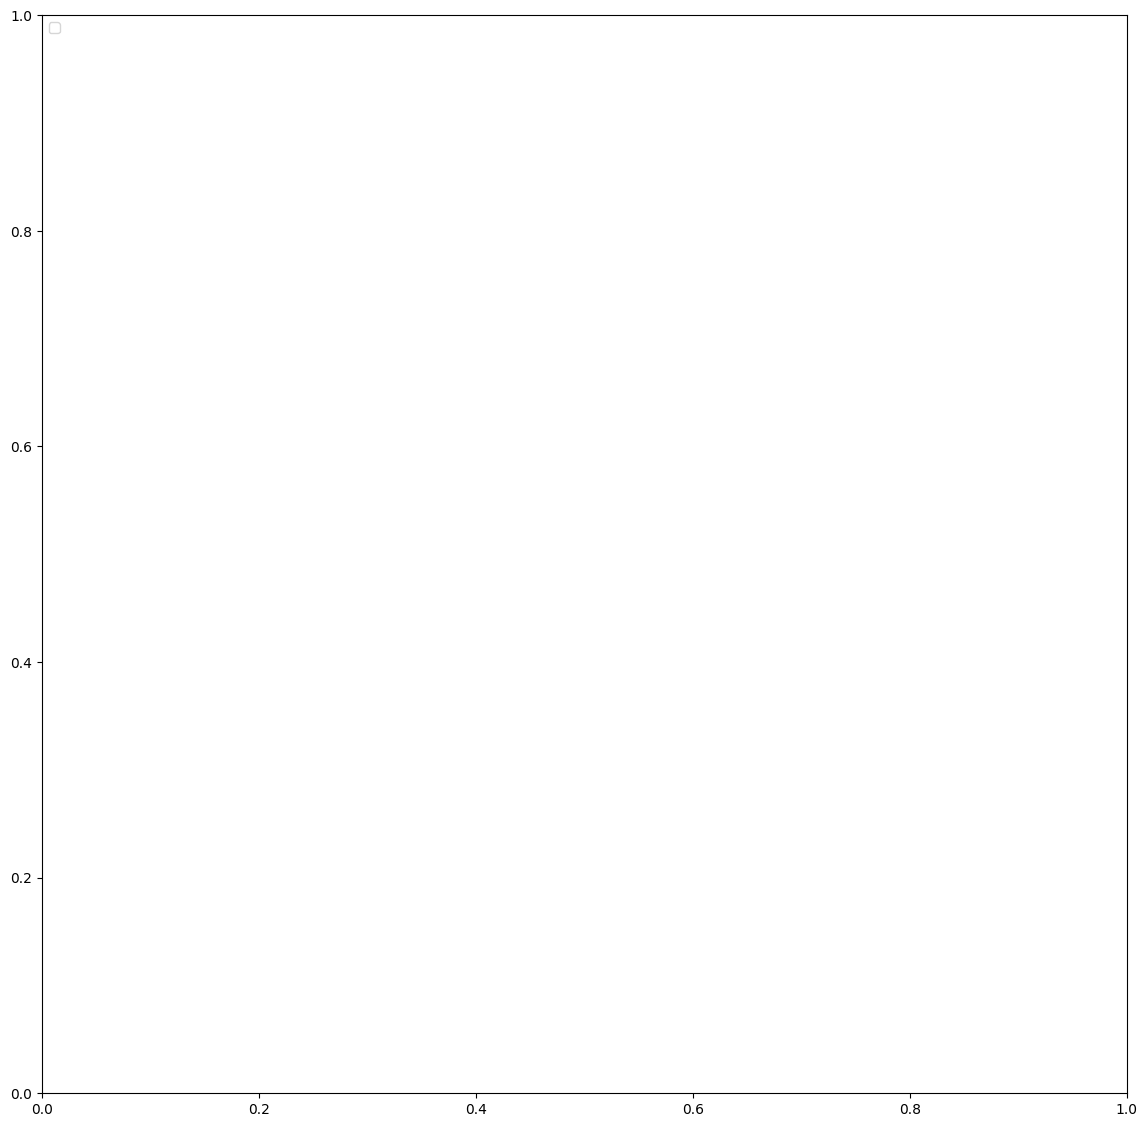

In [ ]:
T = 0.001
t_start = 0
t_finish = 40
a = 1
fig1 = plt.figure(figsize=(8,8))
px1 = fig1.add_subplot(111)
fig2 = plt.figure(figsize=(8, 8))
px2 = fig2.add_subplot(111)
fig3 = plt.figure(figsize=(14, 14))
px3 = fig3.add_subplot(111)
a = 10
c = 0.5
b = 0.60
# Первый элемент это x, второй y
variables = (T, a, b, c)
array0 = [(2, 0)]
array1 = sol.do_method(sol.explicit1_method, T, False)
array2 = do_method(implicit_method, t_start, t_finish, [t_start], [(2, 0)], variables)
array3 = sol.do_method(sol.explicit4_method, T, False)
array4 = sol.do_method(sol.explicit5_method, T, False)
arrayx1 = [i[0] for i in array1[1]]
arrayx2 = [i[0] for i in array2[1]]
arrayy2 = [i[1] for i in array2[1]]
# main_array.append(arrayx3)
# print(len(array1[0]), len(array2[0]), len(arrayx1), len(arrayx2))
# array_dif_x3 = [[i[0] for i in array3_dif]]
# draw([array1[0], array2[0]],
#     [arrayx1, arrayx2],
#     [f"явный 1-го порядка {len(array1[0])}", f"неявный 2го"])
draw_on_plot([array2[0]], [arrayx2], ["Неявный второго порядка"], px1)
draw_on_plot([array3[0]], [[i[0] for i in array3[1]]], [f"Явный четвертого порядка"], px1)
draw_on_plot([array4[0]], [[i[0] for i in array4[1]]], [f"Явный пятого порядка"], px1)
# draw([[i[0] for i in array2[2]]], [arrayx2], [f"{a} value"])
# draw_on_plot([[i[1] for i in array2[1]]], [[i[1] for i in array2[2]]], [f"{round(a, 3)} value"], px2)
# draw_on_plot([arrayx2], [[i[1] for i in array2[1]]], [f"a value: {round(a, 3)}"], px3)
a *= 3
ls = 15
fs = 6
fonts = 15
px1.tick_params(axis="both", which="major", labelsize=ls)
px1.set_xlabel("t", fontsize = fonts)
px1.set_ylabel("X", fontsize = fonts)
px1.legend(fontsize=fonts-3)
px2.tick_params(axis="both", which="major", labelsize=ls)
px2.set_xlabel("t", fontsize = fonts)
px2.set_ylabel("Y", fontsize = fonts)
px2.legend(fontsize=fonts-3)
px1.legend(loc='upper left')
px2.legend(loc='upper left')
px3.legend(loc='upper left')

In [ ]:
from test_methods import *